In [21]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pdb
import pickle 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from os import listdir
from os.path import isfile, join

import torch.nn.functional as F

import random 
import pandas as pd 
import scipy.io as sio
import scipy.signal as sios
import csv
import os
from fastai import *
from fastai.vision import *
import torch
import PIL.Image as Image
import shutil
import pathlib

In [12]:
# initializations 
numSubjects = 17 
numSubjects = 17
dwn_factor = 5 
nE = 127
dataDir = "/home/erl.local/zeinab.schaefer/codes/dataDM/"

trPath = "/home/erl.local/zeinab.schaefer/codes/dataDMSpect/train/"
if os.path.isdir(trPath):
    shutil.rmtree(trPath)
os.mkdir(trPath)

valPath =  "/home/zeinab.schaefer/codes/dataDMSpect/valid/"
if os.path.isdir(valPath):
    shutil.rmtree(valPath)
os.mkdir(valPath)


saveDirRight = "/home/zeinab.schaefer/codes/dataDMSpect/train/right/"
saveDirLeft = "/home/zeinab.schaefer/codes/dataDMSpect/train/left/"
validDataRight = "/home/zeinab.schaefer/codes/dataDMSpect/valid/right/"
validDataLeft = "/home/zeinab.schaefer/codes/dataDMSpect/valid/left/"

if os.path.isdir(saveDirRight):
    shutil.rmtree(saveDirRight)    
os.mkdir(saveDirRight)

if os.path.isdir(saveDirLeft):
    shutil.rmtree(saveDirLeft)    
os.mkdir(saveDirLeft)

if os.path.isdir(validDataRight):
    shutil.rmtree(validDataRight)    
os.mkdir(validDataRight)

if os.path.isdir(validDataLeft):
    shutil.rmtree(validDataLeft)    
os.mkdir(validDataLeft)

#os.mkdir(saveDirLeft)
#os.mkdir(saveDirRight)
#os.mkdir(validData)

In [13]:
# preprocessing data
# Downsample data, save corresponding spectograms 

In [14]:
class Spectrogram(object):
    """Create a spectrogram from a raw audio signal
    Args:
        n_fft (int, optional): size of fft, creates n_fft // 2 + 1 bins
        ws (int): window size. default: n_fft
        hop (int, optional): length of hop between STFT windows. default: ws // 2
        pad (int): two sided padding of signal
        window (torch windowing function): default: torch.hann_window
        power (int > 0 ) : Exponent for the magnitude spectrogram,
                        e.g., 1 for energy, 2 for power, etc.
        normalize (bool) : whether to normalize by magnitude after stft
        wkwargs (dict, optional): arguments for window function
    """
    def __init__(self, n_fft=400, ws=None, hop=None,
                 pad=0, window=torch.hann_window,
                 power=2, normalize=False, wkwargs=None):
        self.n_fft = n_fft
        # number of fft bins. the returned STFT result will have n_fft // 2 + 1
        # number of frequecies due to onesided=True in torch.stft
        self.ws = ws if ws is not None else n_fft
        self.hop = hop if hop is not None else self.ws // 2
        self.window = window(self.ws) if wkwargs is None else window(self.ws, **wkwargs)
        self.pad = pad
        self.power = power
        self.normalize = normalize
        self.wkwargs = wkwargs

    def __call__(self, sig):
        """
        Args:
            sig (Tensor): Tensor of audio of size (c, n)
        Returns:
            spec_f (Tensor): channels x hops x n_fft (c, l, f), where channels
                is unchanged, hops is the number of hops, and n_fft is the
                number of fourier bins, which should be the window size divided
                by 2 plus 1.
        """
        assert sig.dim() == 2

        if self.pad > 0:
            with torch.no_grad():
                sig = torch.nn.functional.pad(sig, (self.pad, self.pad), "constant")
        self.window = self.window.to(sig.device)

        # default values are consistent with librosa.core.spectrum._spectrogram
        spec_f = torch.stft(sig, self.n_fft, self.hop, self.ws,
                            self.window, center=True,
                            normalized=False, onesided=True,
                            pad_mode='reflect').transpose(1, 2)
        if self.normalize:
            spec_f /= self.window.pow(2).sum().sqrt()
        spec_f = spec_f.pow(self.power).sum(-1)  # get power of "complex" tensor (c, l, n_fft)
        return spec_f


class SpectrogramToDB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.
    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip.
    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10. if stype == "power" else 20.
        self.amin = 1e-10
        self.ref_value = 1.
        self.db_multiplier = np.log10(np.maximum(self.amin, self.ref_value))

    def __call__(self, spec):
        # numerically stable implementation from librosa
        # https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html
        spec_db = self.multiplier * torch.log10(torch.clamp(spec, min=self.amin))
        spec_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new_full((1,), spec_db.max() - self.top_db))
        return spec_db

In [15]:
# generate the name of the files 
# the form is FARAH_sub0XY_LS(1/4)_tr(1:4)
# 16 subjects with LS1 and LS4, subject 17 has only LS1
# LS1:Loud speaker to the left 
# LS4:Loud speaker to the right 
fns = []
labels = []
for subject in range(1,numSubjects+1):
    for spk in [1,4]:
        for trial in [1,2]: #range(1,4+1):
            dt = []
            fn = 'FARAH_'+'sub0%0.2d'%subject+'_LS'+str(spk)+'_'+str(trial)
            fns.append(fn)

In [16]:
# downsample data 
#for subject in range(1, numSubjects+ 1):
#    fn = fns[subject]
#    x  = load_dt(fn)
    #pdb.set_trace()
    
#    dwnsampledX = sios.decimate(x, dwn_factor, ftype='fir', axis = 0)
    
#    savename = saveDir + fn + '.npy'
#    np.save(savename, dwnsampledX) 

In [17]:
def normalized_spectogram(signal):
       
    # downsample 127 x T'
    signal = signal[::dwn_factor,:].T
    
    tfm = Spectrogram(512, 512, 32)
    to_db = SpectrogramToDB()

    # shape pf spec 127 x time x freq
    spec = to_db(tfm(torch.from_numpy(signal).float()))
    
    # normalize data between 0 and 255
    # shape of r is torch.size 127 x time x nF  
    r = spec[:,:,:-33]
    r_min = torch.min(r)
    r_max = torch.max(r)
    r = 255 * (r - r_min) / (r_max - r_min)
    
    return r

In [18]:
def generate_subject_name(sn, spk, tr):
    fn = 'FARAH_'+'sub0%0.2d'%sn+'_LS'+str(spk)+'_'+str(tr)
    dt_path = dataDir + fn + '.npy'
    return np.load(dt_path)
    

# Load data, divide into N segments, compute the spectogram and save with label 

In [19]:
opt_seg_dt = True
validSubj = 16

In [20]:
for subject in range(1, numSubjects+1): 
    for spk in [1, 4]:
        for trial in [1,2]:
            
            data = generate_subject_name(subject, spk, trial)    
            r = normalized_spectogram(data)
            
            #pdb.set_trace()
            #print(r.shape)
            
            if opt_seg_dt: # square segments 
                number_of_segments = r.shape[1] // r.shape[2]
                windowSize = r.shape[2]
            else: # no segmentation
                number_of_segments = 1
                windowSize = r.shape[1]
                
                
            fn = 'FARAH_'+'sub0%0.2d'%subject+'_LS'+str(spk)+'_'+str(trial)
            
            if subject == validSubj and trial==1:
                dR = validDataRight
                dL = validDataLeft
            else:
                dR = saveDirRight
                dL = saveDirLeft
                
            for electrode in range(0,nE):#[53, 125, 57, 113, 117, 108, 124, 37, 46]:#[125, 53, 37, 113, 108, 117, 0]:#range(0, nE):
                iStart = 0
                iEnd = windowSize
                for segment in range(0, number_of_segments):
                    
                    img = r[electrode,iStart:iEnd,:].byte().numpy()
                    pil_img = Image.fromarray(img)
            
                    iStart = iEnd + 1
                    iEnd = iEnd + windowSize
                    # create the saving directory 
                    if spk == 1: # Listening to the Right side 
                        save_name = dR + fn + '_e' + np.str(electrode)+ '_seg_' + np.str(segment) +'.png'
                    elif spk == 4:
                        save_name = dL + fn + '_e' + np.str(electrode)+ '_seg_' + np.str(segment) +'.png'
                        
                        
                    pil_img.save(save_name)

# Running the fastai

In [11]:
path = "/home/erl.local/zeinab.schaefer/codes/dataDMSpect/"
#fnames = get_image_files(path)

In [12]:
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.1, ds_tfms=None, size=58) 
data = ImageDataBunch.from_folder(path, size = (224, 224)).normalize()

In [13]:
data

ImageDataBunch;

Train: LabelList (25146 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
left,left,left,left,left
Path: /home/erl.local/zeinab.schaefer/codes/dataDMSpect;

Valid: LabelList (762 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
left,left,left,left,left
Path: /home/erl.local/zeinab.schaefer/codes/dataDMSpect;

Test: None

In [14]:
print(len(data.train_ds) + len(data.valid_ds))
data.train_ds[1]

25908


(Image (3, 224, 224), Category left)

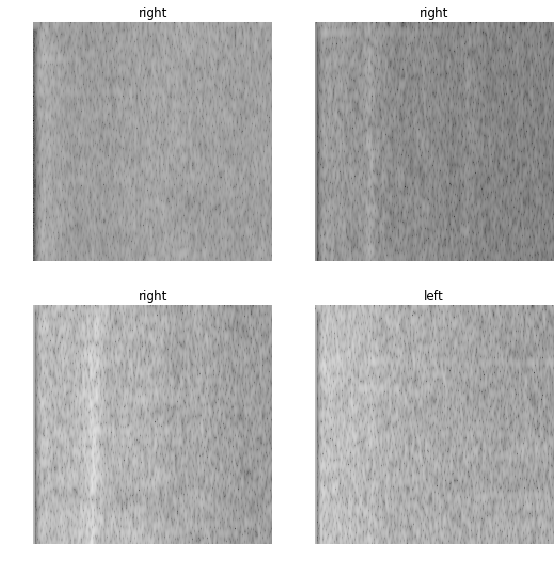

In [15]:
data.show_batch(rows=2, figsize=(8,8))

In [16]:
print(data.classes)

['left', 'right']


In [17]:
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics = accuracy)

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


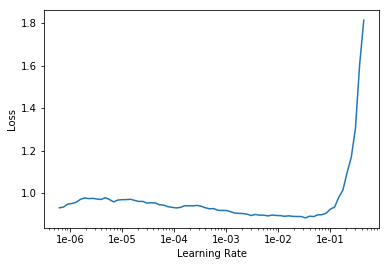

In [20]:
learn.recorder.plot()

In [26]:
lr = 1e-4

In [27]:
learn.fit_one_cycle(6, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.000727,2.587554,0.442257,00:28
1,0.006082,3.468711,0.408136,00:27


KeyboardInterrupt: 

In [ ]:
res = learn.interpret()

In [ ]:
res.plot_confusion_matrix()

In [ ]:
res.confusion_matrix()

In [26]:
learn.fit_one_cycle(5, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.065047,1.442021,0.541995,00:27
1,0.047637,2.527961,0.437008,00:27
2,0.029209,2.362702,0.377953,00:27
3,0.007341,1.894364,0.509186,00:27
4,0.002313,2.010166,0.532808,00:27


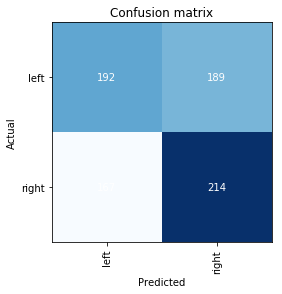

In [27]:
res = learn.interpret()
res.plot_confusion_matrix()

In [28]:
res.confusion_matrix()

array([[192, 189],
       [167, 214]])

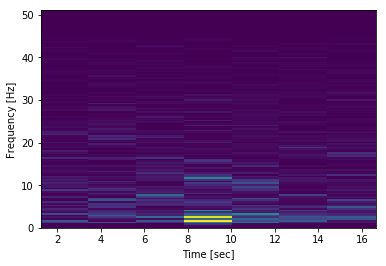

In [87]:
#signal = dt[:, 10]
f, t, Sxx = sios.spectrogram(signal, fs=512//5)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(122880, 127)
122880


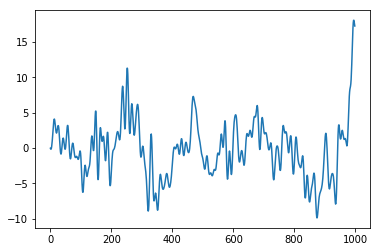

In [10]:
data = generate_subject_name(2, 1, 1)    
print(data.shape)
signal = data[:,10]
plt.plot(signal[0:1000])
print(len(signal))

In [93]:
signal.transpose().shape
newsignal = np.expand_dims(signal, axis = 0)
newsignal.shape

newsignal = newsignal[:, ::5]

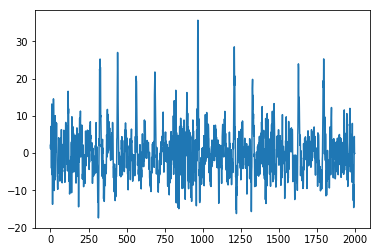

In [96]:
plt.plot(newsignal[0,0:1999])

In [139]:
tfm = Spectrogram(512, 512, 32)
to_db = SpectrogramToDB()
spec = to_db(tfm(torch.from_numpy(newsignal).float()))

In [140]:
#spec = tfm(torch.from_numpy(signal).unsqueeze(0).float())

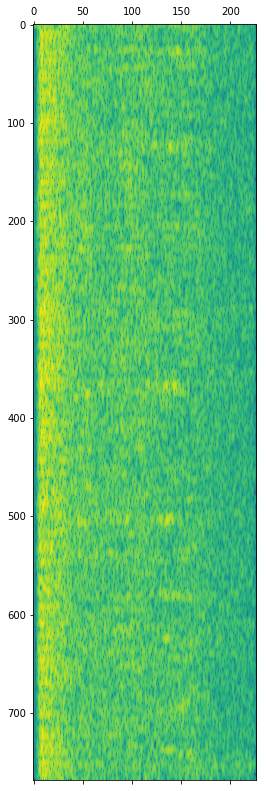

In [146]:
plt.matshow(spec[0,:,:-30])

NameError: name 'spec' is not defined

In [149]:
spec[0,:224,:-33].shape

torch.Size([224, 224])

In [150]:
spec.shape

torch.Size([1, 769, 257])

In [123]:
signal.shape

(127, 24576)

In [163]:
r = spec[:,:,:-7]
r_min = torch.min(r)
r_max = torch.max(r)
r = 255 * (r - r_min) / (r_max - r_min)

In [168]:
img = r[0,:,:].byte().numpy()

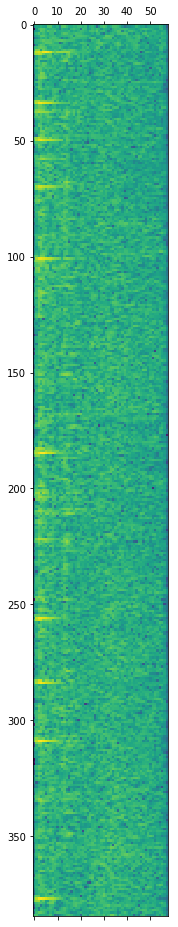

In [166]:
PIL

In [165]:
r[0,:10,:10]

tensor([[211.3180, 208.4035, 199.4544, 182.6759, 186.2648, 203.8101, 204.0563,
         192.7551, 209.3239, 203.2471],
        [162.6008, 184.9381, 183.7608, 189.7144, 184.1313, 179.3955, 200.7818,
         202.3163, 183.2775, 177.9827],
        [ 97.4732, 179.9910, 197.0405, 204.9877, 203.2811, 194.1652, 187.4370,
         191.7571, 194.7706, 190.8600],
        [168.0840, 177.3760, 183.3181, 205.1129, 201.3783, 190.8346, 202.8770,
         197.1187, 196.8278, 201.6811],
        [179.2049, 194.6727, 203.0301, 189.8495, 197.4342, 189.9244, 182.4138,
         196.2768, 195.5143, 170.9077],
        [171.8680, 183.2118, 189.1817, 203.5641, 204.3240, 195.3557, 189.4082,
         191.5887, 194.8348, 195.1286],
        [140.7706, 169.6017, 180.4250, 193.8013, 187.9886, 194.4094, 182.2784,
         196.4407, 201.5361, 198.3584],
        [176.1209, 189.9369, 193.3462, 200.6950, 206.3280, 202.0473, 203.0032,
         201.0437, 196.4532, 199.5701],
        [175.0049, 189.1406, 187.6023, 192.4292,

In [169]:
from PIL import Image

In [170]:
pil_img = Image.fromarray(img)

In [179]:
pil_img.save("/home/erl.local/zeinab.schaefer/codes/first_try.png")

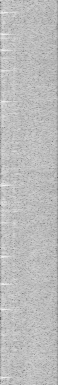

In [174]:
pil_img.convert('L')